In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from collections import Counter

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt

In [2]:
# !! unzip data.zip

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))

    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
######################

In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    
    size = len(index_words_list)
    ran = list(range(size))
    random.shuffle(ran)
    
#     for index_words in index_words_list:
#         for index, center in enumerate(index_words):

    for i in ran:
        for index, center in enumerate(index_words_list[i]):
            context = random.randint(1, context_window_size)
            
            # get a random target before the center word
#             for target in index_words[max(0, index - context): index]:
            for target in index_words_list[i][max(0, index - context): index]:
                yield center, target
            
            # get a random target after the center wrod
#             for target in index_words[index + 1: index + context + 1]:
            for target in index_words_list[i][index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]


def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
#     unique_codones = set(flat_codones)
    
    counter = Counter(flat_codones)
    
    unique_codones = list(set(flat_codones))
    unique_codones = sorted(unique_codones, key=lambda x: counter[x], 
                            reverse=True)
    
#     print(unique_codones[:6])
    
#     count = 0

#     for key in unique_codones:
#         print(key, counter[key])
#         count += 1
#         if count > 6:
#             break
            
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary


def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [9]:
# all_codones = np.array([[['abc', 'gec', 'agc'], ['get', 'ghe', 'acg']]])

dictionary = make_dictionary(all_codones)

print(len(dictionary.keys()))

9424


In [10]:
BATCH_SIZE = 128
SKIP_WINDOW = 10  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [11]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

reading data/all_acid_dicts.pickle


,acid,hydrophobicity,mass,number_of_atoms,volume
0,RQG,-2.800000,113.788733,18.666667,125.766667
1,GPL,0.600000,89.108033,16.333333,113.166667
2,EQI,-0.833333,123.466933,20.333333,149.633333
3,VSD,-0.033333,100.431933,16.333333,113.366667
4,DYC,-0.766667,127.134533,18.000000,137.733333


In [12]:
######################

In [15]:
def create_fully_conn(input_tensor, from_n, to_n, layer_name, activ_func=tf.nn.tanh):
    from_n = int(from_n)
    to_n = int(to_n)

    with tf.name_scope(layer_name):
        W_fc = tf.Variable(tf.truncated_normal(shape=(from_n, to_n), stddev=0.1), name=layer_name + '_W')
        b_fc = tf.Variable(tf.constant(0.1, shape=(to_n,)), name=layer_name + '_b')
        h_fc = activ_func(tf.add(tf.matmul(input_tensor, W_fc), b_fc))
        return h_fc


def create_fully_conn_logit(input_tensor, from_n, to_n, layer_name):
    from_n = int(from_n)
    to_n = int(to_n)

    with tf.name_scope(layer_name):
        W_fc = tf.Variable(tf.truncated_normal(shape=(from_n, to_n), stddev=0.1), name=layer_name + '_W')
        b_fc = tf.Variable(tf.constant(0.1, shape=(to_n,)), name=layer_name + '_b')
        h_fc = tf.add(tf.matmul(input_tensor, W_fc), b_fc)
        return h_fc    

class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')
    
    def _create_embedding(self):
        with tf.name_scope("embed"):
            base_var = tf.Variable(tf.truncated_normal([self.vocab_size,
                                                               self.embed_size], stddev=0.1),
                                            name='embed_matrix')
            
            base_ratio = 1.
            fc1_ratio = 1.5
            fc2_ratio = 2.
            fc3_ratio = 2.5
            
            #DenseNet little brother
            fc1 = create_fully_conn(base_var, self.embed_size, self.embed_size * fc1_ratio,
                                          'fc1', tf.nn.elu)
            fc2 = create_fully_conn(fc1, self.embed_size * fc1_ratio, self.embed_size * fc2_ratio, 
                                          'fc2', tf.nn.sigmoid)
            
            con_12 = tf.concat([fc1, fc2], axis=1)
            con_12_size = self.embed_size*(fc1_ratio + fc2_ratio)
            
            
            fc3 = create_fully_conn(con_12, con_12_size, self.embed_size * fc3_ratio,
                                    'fc3', tf.nn.relu)
            
            con_23 = tf.concat([fc2, fc3], axis=1)
            con_23_size = self.embed_size*(fc3_ratio + fc2_ratio)
            
            self.embed_matrix = create_fully_conn_logit(con_23, con_23_size, self.embed_size, 'em')

    def _create_loss(self):
        with tf.name_scope("loss"):
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
                                                      inputs=embed,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
#         self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
#         self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
        self.optimizer = tf.train.AdagradOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [16]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 16  # Number of negative examples to sample.
LEARNING_RATE = .001
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [17]:
######################

In [18]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [19]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    
    with tf.Session(graph=g, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
#             print(centers[:5], targets[:5])
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [20]:
final_embed_matrix = train_model(model, batch_gen, 30000, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999:  51.7
Average loss at step 3999:  40.2
Average loss at step 5999:  34.7
Average loss at step 7999:  30.6
Average loss at step 9999:  28.6
Average loss at step 11999:  26.4
Average loss at step 13999:  24.5
Average loss at step 15999:  22.4
Average loss at step 17999:  21.8
Average loss at step 19999:  20.9
Average loss at step 21999:  20.1
Average loss at step 23999:  18.7
Average loss at step 25999:  18.0
Average loss at step 27999:  17.6
Average loss at step 29999:  17.0


In [21]:
######################

In [22]:
def plot_tsne_df(matrix):
    tsne = TSNE(n_components=2, random_state=42)
    XX = tsne.fit_transform(matrix)
    
    tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
    unique_codones = sorted(dictionary, key=dictionary.get)
    tsne_df['codone'] = list(unique_codones)
#     tsne_df.head()
    
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(tsne_df.x0, tsne_df.x1, s=10)
    plt.show()
    
    return tsne_df

In [23]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

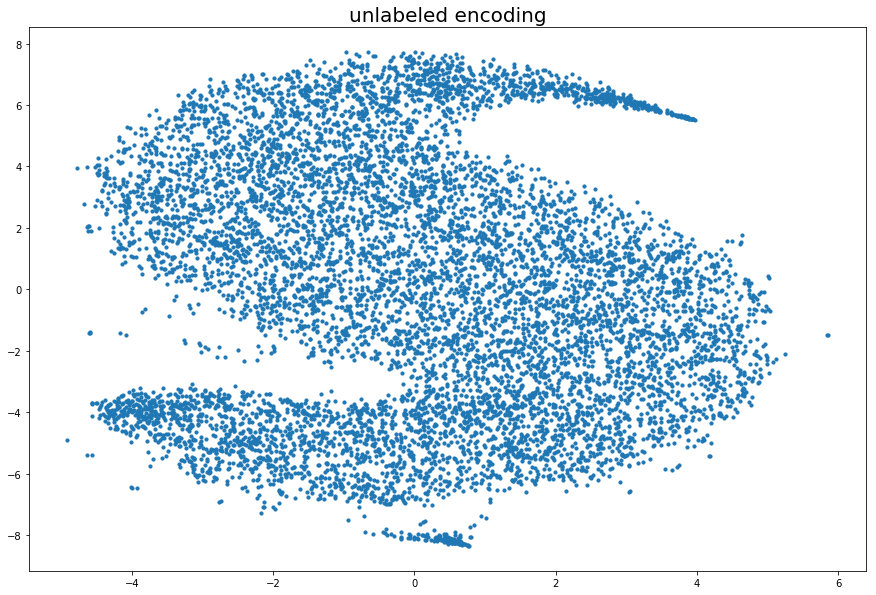

In [24]:
tsne_df = plot_tsne_df(final_embed_matrix)

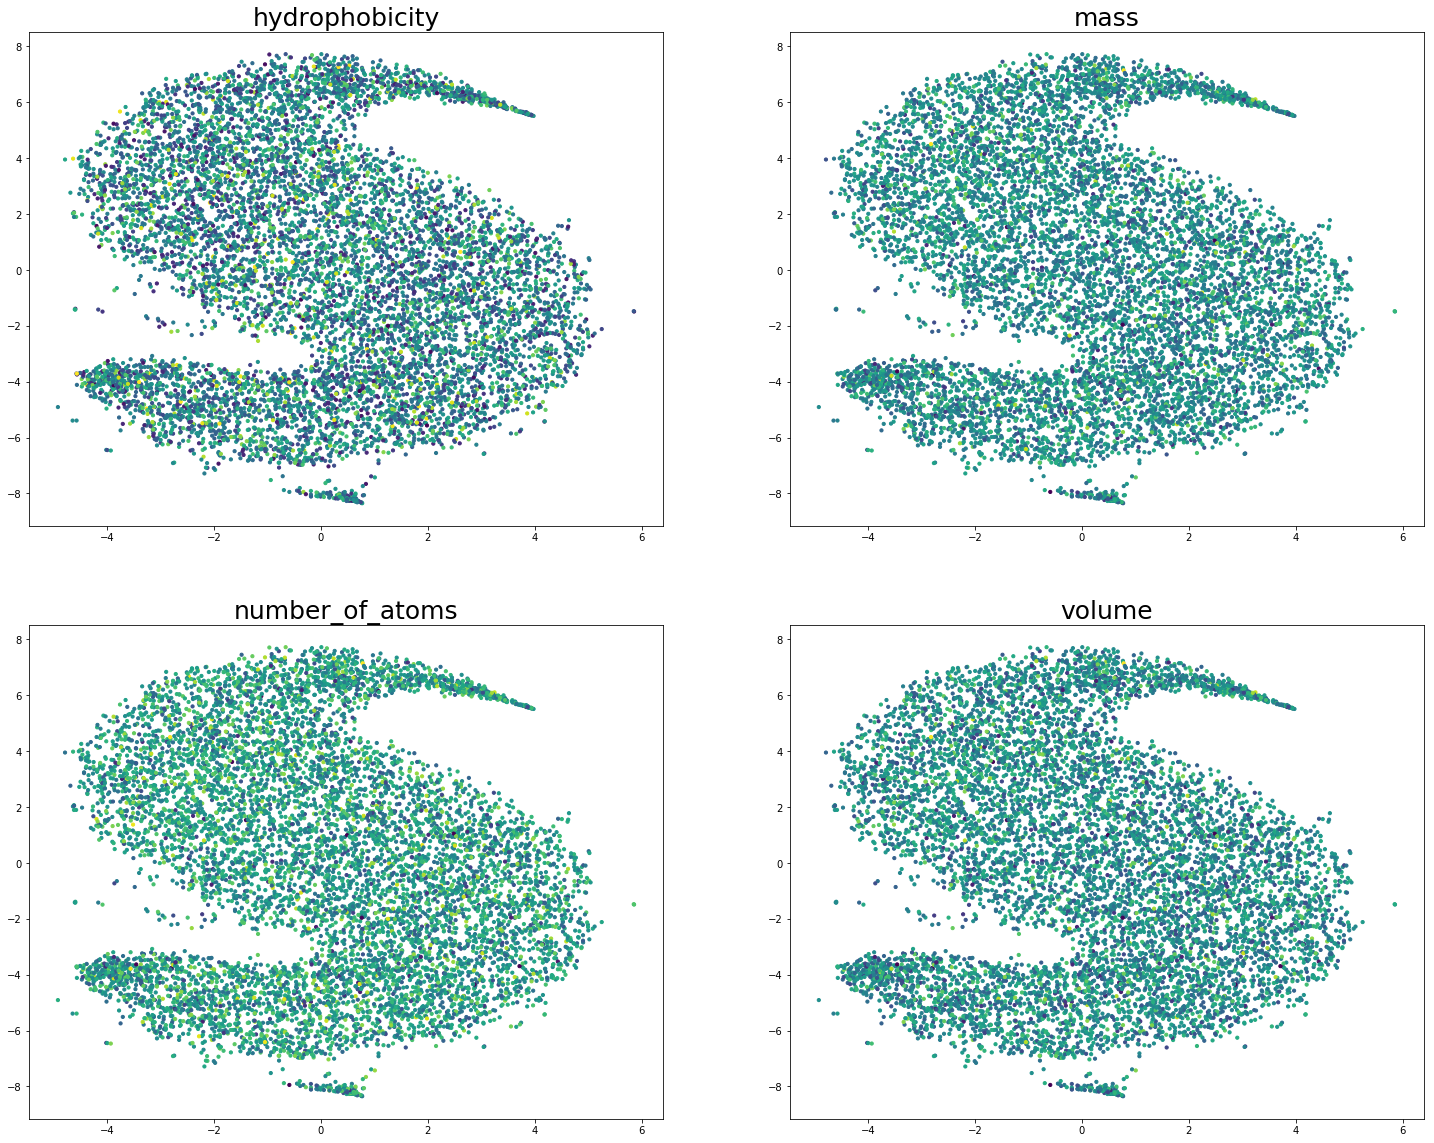

In [25]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
# final_df.head()
plot_embedding_properties(final_df)

In [ ]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

In [ ]:
plot_tsne_df(gensim_tsne_df)

In [ ]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

In [ ]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/